In [30]:
#import libraries

#sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

#os library
from os import listdir
from os.path import isdir,join

#other libraries
import numpy as np
import h5py
import cv2 as cv
import statistics
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings

# input/output paths
# this ipynb file MUST be placed in 'English' folder to work properly
path_find_images =  './Hnd/Img'
#path_output_grid = './grid_output.csv' #only used to output results


In [29]:
#load data, preprocess (normalise,invert,resize,add average pixel data(optional))
def load_data(file_path, pixels_ld, extra_feature_ld):
    """
    This function converts raw image data into numpy arrays. It takes in as arguments the path directory of the dataset [file_path],
    the image size in pixels [pixels_ld x pixels_ld] and a boolean [extra_feature_ld] for optional feature extraction of mean value of the pixel
    data. 
    After reading in the raw image files, each image is converted to grayscale, inverted, bounded, flattened and finally normalised to ensure each
    image is universally defined. If the extra feature option is True, an additional feature of the mean pixel value is calculated and appended to
    the image. 
    The function returns the images and corresponding labels as a numpy array. 
    """
    target = [] # labels array(integer format items)
    target_names = [] # labels array(string format items)
    filenames = [] # path to each Img(string format items)

    container_path = file_path
    folders = [f for f in sorted(listdir(container_path)) if isdir(join(container_path, f))]

    # initialize target, target_names and filenames
    for label, folder in enumerate(folders):
        target_names.append(folder)
        folder_path = join(container_path, folder)
        documents = [join(folder_path, d) for d in sorted(listdir(folder_path))]
        target.extend(len(documents) * [label])
        filenames.extend(documents)

    # convert to nparray
    filenames = np.array(filenames) # full paths for each img
    target = np.array(target) # label for each img (corresponding to "filenames" array)

    #load and preprocess images
    img_array = [] # to store all flatten images
    # resize shape
    rows,cols = pixels_ld, pixels_ld
    for filename in filenames:
        read_img = cv.imread(filename)
        gray = cv.cvtColor(read_img,cv.COLOR_BGR2GRAY)
        ret,thresh = cv.threshold(gray,127,255,cv.THRESH_BINARY_INV) 
        contours, hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE) 
        cnt = contours[0]
        x,y,w,h = cv.boundingRect(cnt) # get the rectangle 
        thresh = thresh[y:y+h,x:x+w] # cut the image
        thresh = cv.resize(thresh,(rows,cols)).flatten() # resize to same size
        img_array.append(thresh/255)
    image = np.array(img_array)
    #add column containing average pixel data for each object
    if extra_feature_ld:
        image = np.append(image,np.zeros((image.shape[0],1)),axis=1)
        for i in range(image.shape[0]):
            image[i, image.shape[1]-1] = sum(image[i,:rows*cols])/(rows*cols)
    return image,target


# option to write and read hdf5 files to avoid having to load each image from a file each time
def write_hdf5(filename, h5dataset_name, dataset):
    """Function to write data to a hdf5 file. The h5 filename, dataset name and the dataset must be passed as arguments."""
    with h5py.File(filename, 'w') as H:
        H.create_dataset(h5dataset_name, data = dataset)
def read_hdf5(filename, h5dataset_name):
    """
    Function to load data from a hdf5 file. The h5 filename and dataset name must be passed as arguments. This function returns
    the dataset as a numpy array. 
    """
    with h5py.File(filename,'r') as H:
        data = np.copy(H[h5dataset_name])
    return data

# algorithm
def classifier(X_train,y_train,X_test, cp1_cl, cp2_cl):
    """
    This function defines the Gaussian Naive Bayes and Logistic Regression classifiers from the sklearn library. 
    It takes in arguments for training data and labels, test data, and returns the predicted labels. 
    IMPORTANT: please uncomment the classifier that is not being tested. E.g. if Naive Bayes algorithm needs to run, 
    uncomment Naive Bayes and comment out Logistic Regression classifier. 
    """
    warnings.filterwarnings('ignore') #to ignore convergence warnings while running logistic regression classifier
    clf = LogisticRegression(C=1, class_weight='balanced', penalty=cp1_cl, solver='saga', multi_class=cp2_cl).fit(X_train,y_train)
    #clf = GaussianNB().fit(X_train,y_train)    
    predictions = clf.predict(X_test)
    return predictions



In [40]:
# principal components analysis application
def pca_reduction(X_train, X_test,components):
    """
    This function is used to reduce the dimensionality of the training and test data. It takes in as arguments training data, test data and 
    the number of PCA components the user wants to retain after PCA transformation.
    This function returns the transformed training and test data. 
    """
    X_t_scaled = preprocessing.scale(X_train)
    X_v_scaled = preprocessing.scale(X_test)
    pca = PCA(n_components=components, random_state=1).fit(X_t_scaled)
    X_t_PCA = pca.transform(X_t_scaled)
    X_v_PCA = pca.transform(X_v_scaled)
    #print(pca.explained_variance_ratio_.sum())
    return X_t_PCA,X_v_PCA

# split the dataset into training and testing subsets
def tr_te_split(data_ts, labels_ts):
    """This function splits dataset and labels into training set and test set in a 4:1 ratio. It returns the split data."""
    return train_test_split(data_ts, labels_ts, test_size = 0.2, shuffle=False)

#plot confusion matrix
def plot_matrix(X_t,y_t,X_v,y_v,cp1_cl, cp2_cl):
    """
    This function is used to plot the confusion matrix generated by the model with the best parameters. It takes in as arguments
    the training set, test set and other parameters for the Random Tree classifier. It returs the plot of the confusion matrix.
    NOTE: the command to save the plot as a .png file has been commented out to avoid unwanted overwriting of files. Please uncomment 
    this command if you wish to save the plot as a .png file. Keep in mind that any file named 'confusion_matrix.png' in the working 
    directory will be overwritten if this command is executed. 
    IMPORTANT: please uncomment the classifier that is not being tested. E.g. if Naive Bayes algorithm needs to run, 
    uncomment Naive Bayes and comment out Logistic Regression classifier. 
    """
    #clf = GaussianNB().fit(X_t,y_t)
    clf = LogisticRegression(C=1, class_weight='balanced', penalty=cp1_cl, solver='saga', multi_class=cp2_cl).fit(X_t,y_t)
    char_ticks = [0,9,10,37,38,61] #indices for 0,9,A,Z,a,z
    char_labels = ['0','9','A','Z','a','z']
    plot_confusion_matrix(clf,X_v,y_v, cmap='hot',include_values=False,normalize='true') 
    plt.title("Confusion Matrix",fontsize=16)
    plt.xlabel("Predicted characters 0-9, A-Z, a-z",fontsize=12)
    plt.ylabel("Actual characters 0-9, A-Z, a-z",fontsize=12)
    plt.xticks(char_ticks, char_labels,fontsize=12)
    plt.yticks(char_ticks, char_labels,fontsize=12)
    plt.gcf().set_size_inches(20, 10)
    plt.savefig('confusion_matrix.png',dpi=100)
    
# split datasets for k-fold cross validation
def kfold_cv(folds,data,labels,pca_option,components, cp1_kf, cp2_kf):
    """
    This function implements a k-fold cross validation technique using sklearn. It splits data into training and test data k times 
    in a random order. It takes in user-defined number of folds [folds], the dataset, a boolean to check if user wants to apply
    PCA [pca_option], number of PCA components to retain [components] and parameters for the Random Tree classifier. 
    This function makes use of all functions defined above and is a crucial part of this model. 
    This function returns a list which contains the mean values of scoring metrics for the model.
    """
    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    kf.get_n_splits(data)
    result_scores = np.zeros((folds,10))
    fold_num = 0
    for train_index, test_index in kf.split(data):
        #print('{}-fold CV: Fold = {}'.format(folds, fold_num+1))
        X_t = data[train_index,:]
        X_v = data[test_index,:]
        y_t = labels[train_index]    
        y_v = labels[test_index]
        
        #PCA
        if pca_option:
            X_t, X_v = pca_reduction(X_t, X_v,components)
        
        #algorithm
        labels_p = classifier(X_t,y_t,X_v, cp1_kf, cp2_kf)
        
        #model evaluation 
        #note that zero division warnings have been suppressed in following code 
        fold_result = classification_report(y_v,labels_p, output_dict=True, zero_division = 0)
        result_scores[fold_num,0] = fold_result['accuracy']
        result_scores[fold_num,1] = fold_result['macro avg']['precision']
        result_scores[fold_num,2] = fold_result['macro avg']['recall']
        result_scores[fold_num,3] = fold_result['macro avg']['f1-score']
        fold_num += 1
        
        #printing confusion matrix for one random train-validation set
        if fold_num == 1:
            plot_matrix(X_t,y_t,X_v,y_v, cp1_kf, cp2_kf)   
    return result_scores

#print model evaluation results
def print_stats(results):
    """This function is used to print the scoring metrics of the model obtained using k-fold cross validation."""
    print('Final test sample result - accuracy: ', statistics.mean(results[:,0]))
    print('Final test sample result - precision: ', statistics.mean(results[:,1]))      
    print('Final test sample result - recall: ', statistics.mean(results[:,2]))
    print('Final test sample result - f1-score: ', statistics.mean(results[:,3]))

def preloaded(data_pl, labels_pl, pc_pl, cp1_pl, cp2_pl):
    """
    This function carries out 10 fold cross validation on the model with the best parameters. It takes in 
    data and labels, number of PCA components and parameters needed for the Random Tree classifier. 
    """
    X_tr, X_te, y_tr, y_te = tr_te_split(data_pl, labels_pl)
    results = kfold_cv(10,data,labels,True,pc_pl,cp1_pl, cp2_pl)
    print_stats(results)
    return statistics.mean(results[:,0])



### Notes on running the following cell
- After all the above functions have been defined, the next cell runs the model and prints scoring metrics and plots a confusion matrix.
- Please note that the cell below can be used for grid search for hyperparameter tuning and/or to evaluate the model. For convenience, we have commented out the grid search section for hyperparameter tuning of the model. Instead, we have predetermined the best paramers for the model and applied it to the cell already. 
- **IMPORTANT: Please make sure the correct classifier has been commented out, i,.e. if using Naive Bayes, the Logistic Regression classifier must be commented out in classifier() and plot_matrix() functions.**
- If grid search does need to be performed please uncomment the parameters as shown below. Please refer to Appendix A1 in the report for more details on running the grid search. 
- Thank you :)


Loading data with 400 pixels:  2020-11-18 13:51:34.111803
Load complete,  2020-11-18 13:52:30.266372
Start run with settings:  20 False 32 l1 multinomial 2020-11-18 13:52:30.266372
Final test sample result - accuracy:  0.7164222873900293
Final test sample result - precision:  0.711657759802921
Final test sample result - recall:  0.7141332681655262
Final test sample result - f1-score:  0.6934976919342569
Completed run with settings:  20 False 32 l1 multinomial 2020-11-18 13:53:32.671225


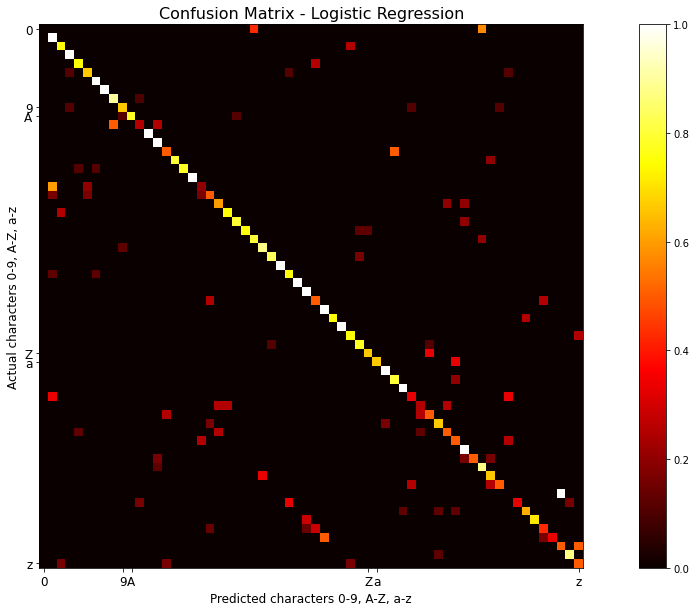

In [39]:
"""
Parameters for grid search
To run grid search, please replace each parameter and hyperparameter with the following lists.
pixel size (i.e px x px = image size): px = [6, 20, 45, 80]
pca_component: pc = [8,16,32,64]
extra features: ef = [True,False]
The following hyperparameters apply to Logistic Regression ONLY (Naive Bayes does not have any)
regularization: cp1 = ['l1','l2']
type: cp2 = ['ovr','multinomial']
"""

grid_results = []
#initialisation
px, ef, pc, cp1, cp2 = 0,False,0,0,0

#best params for logistic regression: px = 20, ef = False, pc = 32
#best params for naive bayes: px = 45, pc = 64
#see Table in 'Best Performance' subsection of 'Results' in report for more information


# perform the combinations of all grid search parameters in loops
for px in [20]: #data pixels
    for ef in [False]: #extra features
        print('Loading data with',px**2, 'pixels: ', datetime.datetime.now())
        data, labels = load_data(path_find_images,px,ef) 
        print('Load complete, ', datetime.datetime.now())
        for pc in [32]: #pca number       
            if pc < px**2:       
                for cp1 in ['l1']: #regularization for logistic regression 
                    for cp2 in ['multinomial']: # type of regression                                          
                            print('Start run with settings: ', px, ef, pc, cp1, cp2, datetime.datetime.now())
                            a = datetime.datetime.now()
                            grid_results.append([px, ef, pc, cp1, cp2, preloaded(data, labels, pc, cp1, cp2), a, datetime.datetime.now()])
                            #pd.DataFrame(np.array(grid_results)).to_csv(path_output_grid)                           
                            print('Completed run with settings: ', px, ef, pc, cp1, cp2, datetime.datetime.now())

